In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyUSID as usid
import h5py

%matplotlib inline

In [4]:
data_dir = '../data'

In [6]:
data = np.load(os.path.join(data_dir, 'Coord-Matt-data-d.npy'))[()]

In [28]:
print('Keys:', data.keys())
print('Values:', data['Re05']['image'].shape, data['Re05']['coordinates'])

Keys: dict_keys(['Re05', 'Re95', 'Re78', 'Re55'])
Values: (512, 512) [[5.71698113e+00 6.15094340e+00]
 [6.03333333e+00 2.64000000e+01]
 [5.74137931e+00 4.62931034e+01]
 ...
 [5.07851852e+02 4.84370370e+02]
 [5.07800000e+02 5.06090909e+02]
 [5.11000000e+02 5.00000000e-01]]


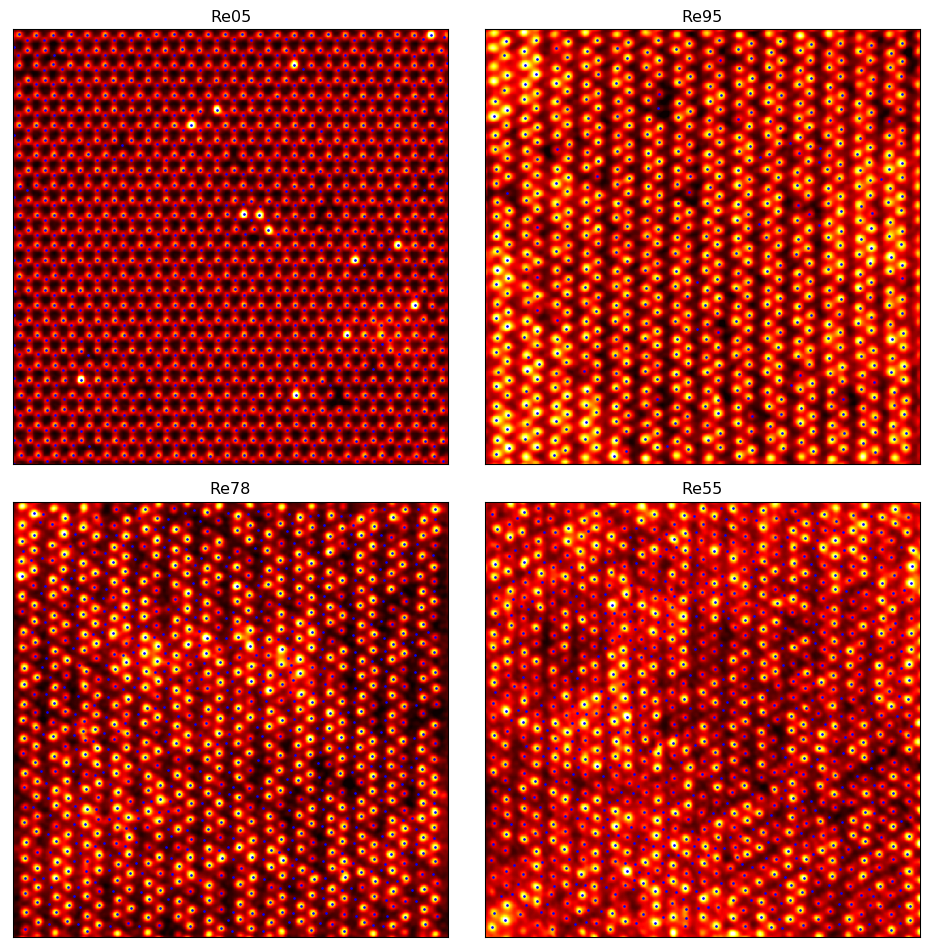

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi = 96)

for i, (k, v) in enumerate(data.items()):
    y, x = v['coordinates'].T
    imgdata = v['image']

    ir, ic = divmod(i, 2)
    axs[ir, ic].scatter(x, y, c = 'blue', s = 1)
    axs[ir, ic].imshow(imgdata, cmap = 'hot')
    axs[ir, ic].get_xaxis().set_visible(False)
    axs[ir, ic].get_yaxis().set_visible(False)
    axs[ir, ic].set_title(k)

plt.tight_layout()
plt.show()

## Analyze image data in h5 files to collect histograms

* The atoms have been found and separated into sub lattices using Stephen's method.


In [45]:
# Set h5 files name list
h5_names = [os.path.join(data_dir, k.lower()+'.h5') for k in data]
h5_names

['../data/re05.h5', '../data/re95.h5', '../data/re78.h5', '../data/re55.h5']

**Define distance function** 

In [46]:
def dist_calc(pt, pts):
    """Distance between a point 'pt' and a list of points 'pts'"""
    
    dist_mat = []
    for ind in range(pts.shape[0]):
        dist_mat.append((np.sqrt((pt[0] - pts[ind,0])**2 + (pt[1] - pts[ind,1])**2), ind))
    
    return np.array(dist_mat)

### Re05 image

In [33]:
#let's look at the first one
h5_file = h5py.File(h5_names[0], 'r+')
h5_raw = h5_file['Measurement_000']['Channel_000']['Raw_Data']

In [36]:
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Atom_Positions
      --------------
      ├ Atom_Centroids_1
      ├ Atom_Centroids_2
      ├ Cropped_Image
    ├ Atom_Positions_2
      ----------------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [47]:
atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
atom_centroids_2 =  atom_pos_grp['Atom_Centroids_2']
cropped_image = atom_pos_grp['Cropped_Image'][:]

In [53]:
atom_centroids_2.shape

(550, 2)

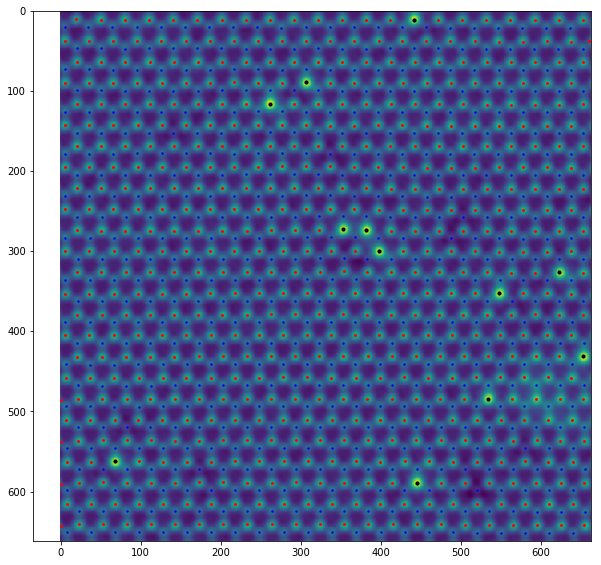

In [6]:
plt.figure(figsize = (10,10))
plt.imshow(cropped_image[:])
dopant_atoms = []
Mo_atoms=[]
for i in range(atom_centroids_1.shape[0]):
    re_x = int(atom_centroids_1[i,0])
    re_y = int(atom_centroids_1[i,1])
    plt.scatter(re_y, re_x, s=4, c = 'r')
    
    if cropped_image[re_x,re_y]>=0.80:
        plt.scatter(re_y, re_x, s=10, c = 'k')
        dopant_atoms.append((re_x, re_y))
    else:
        Mo_atoms.append((re_x,re_y))
for i in range(atom_centroids_2.shape[0]):
    re_x = atom_centroids_2[i,0]
    re_y = atom_centroids_2[i,1]
    plt.scatter(re_y, re_x, s=2, c = 'b')

In [7]:
Mo_atoms = np.array(Mo_atoms)
dopant_atoms = np.array(dopant_atoms)

all_atoms = np.vstack((Mo_atoms[:], dopant_atoms[:])) #ignoring the sulfur atoms for now.

In [8]:
print(all_atoms.shape)

(555, 2)


In [9]:
all_atoms_ids = np.zeros(all_atoms.shape[0])
all_atoms_ids[:Mo_atoms.shape[0]]=0 #0 means Mo
all_atoms_ids[Mo_atoms.shape[0]:]=1 #1 is dopant atom

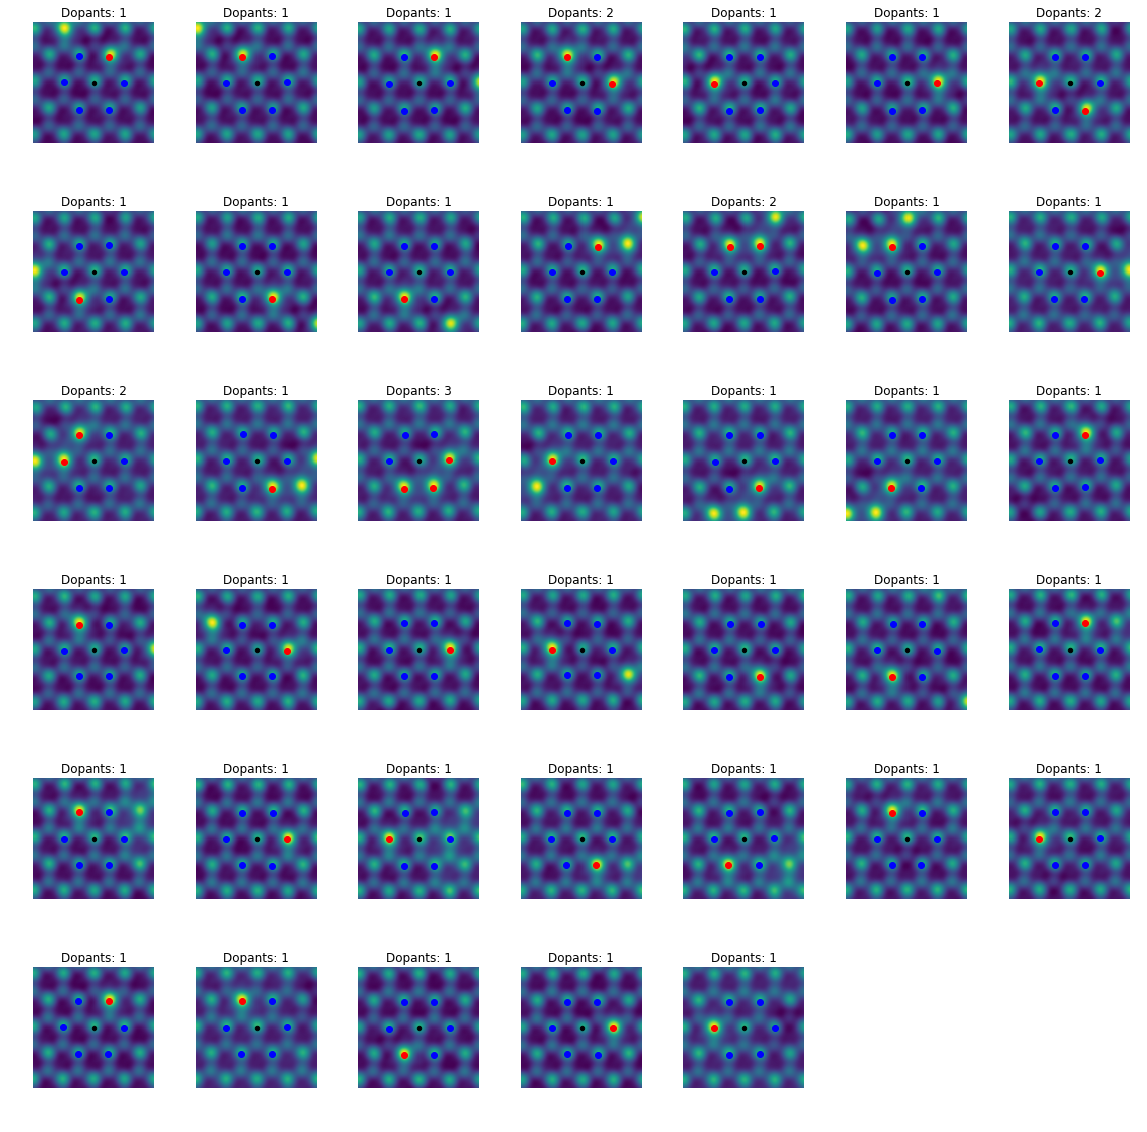

In [10]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 40 #For all atoms found within this radius, keep them

#Here we want to plot any atom which has a dopant surrounding it.

fig, axes = plt.subplots(nrows=6, ncols=7, figsize = (16,16))
flat_axes = axes.flat

ax_ind = 0

histogram=[]

for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    plot_image = False
    #Plot the image only if a dopant atom is found. 
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1:
            plot_image =True
    
    if plot_image==False: #this means no NN were dopants
        histogram.append(1) #So this is the first type of configuration
    
    if plot_image==True:
        min_x_coord = int(max(0,x-win_size))
        max_x_coord = int(min(cropped_image.shape[1], x+win_size))

        min_y_coord = int(max(0,y-win_size))
        max_y_coord = int(min(cropped_image.shape[0], y+win_size))

        img_width =max_x_coord - min_x_coord 
        img_height =max_y_coord - min_y_coord

        if img_width<win_size*2: #ignore edge cases
            pass
        elif img_height<win_size*2:
            pass
        elif atom_ind==1:
            pass
        else:
            #Now that we have the neighbors, let's plot them.
            #First we plot the original atom.
            shifted_x_pos = x-min_x_coord 
            shifted_y_pos = max_y_coord - y 

            cropped_atom_img = np.flipud(cropped_image[min_x_coord:max_x_coord, min_y_coord:max_y_coord])
            
            flat_axes[ax_ind].imshow(cropped_atom_img)
            
            flat_axes[ax_ind].scatter(shifted_y_pos, shifted_x_pos, c='black', s=20)
            
            num_dopants=0
            dopant_neighbor = []
            for neighbor_ind in neighbors:
                if all_atoms_ids[neighbor_ind]==1: 
                    num_dopants+=1
                    dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
                
            for neighbor_ind in neighbors:
                
                dopant_x, dopant_y = all_atoms[neighbor_ind,:]
                #print(dopant_x, dopant_y,x,y)
                
                dopant_shifted_x_pos = max_x_coord - dopant_x
                dopant_shifted_y_pos = dopant_y -min_y_coord 
                
                if all_atoms_ids[neighbor_ind]==1:
                    flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='r')
                else:
                    flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='b')
            flat_axes[ax_ind].set_title('Dopants: {}'.format(num_dopants))
            flat_axes[ax_ind].axis('off')
            ax_ind = ax_ind+1
            
            #Now to make the histogram.
            #If one dopant, then it doesn't matter
            #If two dopants, then check the distance between the two dopant atoms.
            #print out the distance
            
            if num_dopants==1:
                histogram.append(2) #only one configuration 
            if num_dopants==2: #there are two types of configurations. So check which one...
                #the dopant atom indices are in dopant_neighbor.
                #calculate the distance between the dopant atoms
                x1,y1 =all_atoms[dopant_neighbor[0],:]
                x2,y2 =all_atoms[dopant_neighbor[1],:]
                dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
                flat_axes[ax_ind].set_title('2 D, d={}'.format(np.round(dist,2)))
                #here we check for the type of configuration in the two dopant neighbor case
                if dist<=35:
                    histogram.append(4) #cis
                else:
                    histogram.append(3) #trans
            elif num_dopants==3:
                histogram.append(5) #only one configuration of this type
                    

for ax in flat_axes: ax.axis('off')
fig.tight_layout()

# Configuration Possibilities 

<font size = 3>The configurations we look for can be seen in the following figure. We assume the S lattice is perfect and are not concerned with S vacancies. We simply look for the NN atoms of Mo that are either Mo atoms or Re atoms. There are 13possible configurations (all others are symmetrical with respect to these).</font>


<img src = "Mo_Re_configurations.png"></img>

[0.92523364 0.06542056 0.00373832 0.00373832 0.00186916 0.
 0.         0.         0.         0.         0.         0.
 0.        ]


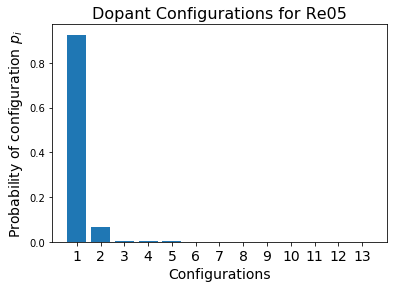

In [11]:
counts, bin_edges = np.histogram(histogram,bins=13, range=(1,13))
counts_norm = counts/len(histogram) #divide by number of counted configurations

fig, axes = plt.subplots();
axes.bar(np.arange(1,len(counts_norm)+1),counts_norm)
axes.set_xticks(np.arange(1,len(counts_norm)+1));
axes.set_xticklabels(np.arange(1,len(counts_norm)+1), fontsize = 14);
axes.set_title('Dopant Configurations for Re05', fontsize = 16);
axes.set_ylabel("Probability of configuration $p_i$", fontsize = 14);
axes.set_xlabel("Configurations", fontsize = 14);

print(counts_norm)

In [12]:
counts_norm

array([0.92523364, 0.06542056, 0.00373832, 0.00373832, 0.00186916,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [13]:
h5_file.file.close()

# Now analyze histogram of configurations with Re55

In [14]:
#let's look at the first one
#The atoms have been found and separated into sub lattices using Stephen's method.

h5_path = r're55.h5'
h5_file = h5py.File(h5_path, 'r+')
h5_raw = h5_file['Measurement_000']['Channel_000']['Raw_Data']

In [15]:
usid.hdf_utils.print_tree(h5_file)
atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
atom_centroids_2 =  atom_pos_grp['Atom_Centroids_2']
cropped_image = atom_pos_grp['Cropped_Image'][:]

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Atom_Positions
      --------------
      ├ Atom_Centroids_1
      ├ Atom_Centroids_2
      ├ Cropped_Image
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Windowing_000
      ----------------------
      ├ Image_Windows
      ├ Image_Windows-SVD_000
        ---------------------
        ├ Cleaned_Image_000
          -----------------
          ├ Cleaned_Image
        ├ Position_Indices
        ├ Position_Values
        ├ S
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
        ├ U
        ├ U-Cluster_000
          -------------
          ├ Cluster_Indices
          ├ Cluster_Values
          ├ Labels
          ├ Mean_Resp_Pos_Indices
          ├ Mean_Resp_Pos_Values
          ├ Mean_Response
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
        ├ V
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic

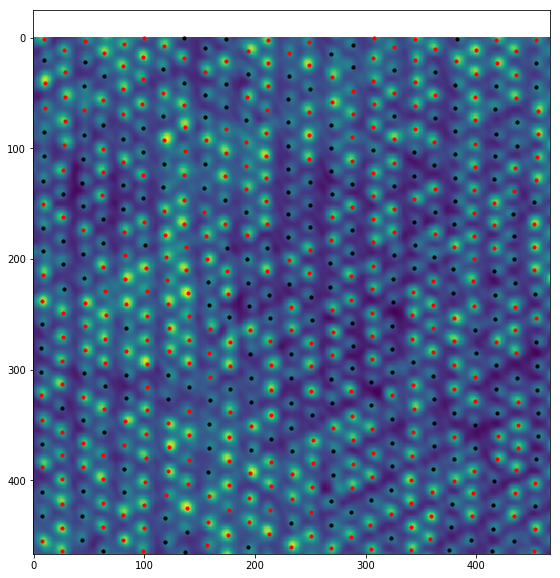

In [16]:
plt.figure(figsize = (10,10))
plt.imshow(cropped_image)
dopant_atoms = []
Mo_atoms=[]
for i in range(atom_centroids_1.shape[0]):
    x,y = atom_centroids_1[i,:]
    
    if cropped_image[int(x),int(y)]>=0.45:
        plt.scatter(atom_centroids_1[i,1],atom_centroids_1[i,0], c='r', s=10)
        dopant_atoms.append((x,y))
    else:
        plt.scatter(atom_centroids_1[i,1],atom_centroids_1[i,0], c='k', s=10)
        Mo_atoms.append((x,y))

In [17]:
Mo_atoms = np.array(Mo_atoms)
dopant_atoms = np.array(dopant_atoms)

all_atoms = np.vstack((Mo_atoms[:], dopant_atoms[:])) #ignoring the sulfur atoms for now.

print(all_atoms.shape)

all_atoms_ids = np.zeros(all_atoms.shape[0])
all_atoms_ids[:Mo_atoms.shape[0]]=0 #0 means Mo
all_atoms_ids[Mo_atoms.shape[0]:]=1 #1 is dopant atom
h5_file.file.close()

(557, 2)


In [18]:
#Some helper functions

def get_distance(atom_1,atom_2):
    return np.sqrt((atom_1[0]-atom_2[0])**2 + (atom_1[1]-atom_2[1])**2)

def classify_three_dopant_class(dopant_atom_pos):
    atom_1 = dopant_atom_pos[0,:]
    atom_2 = dopant_atom_pos[1,:]
    atom_3 = dopant_atom_pos[2,:]
    
    sum_distance = get_distance(atom_1,atom_2) + get_distance(atom_1,atom_3) + get_distance(atom_2,atom_3)
    
    if sum_distance<=85:
        three_d_class = 5
    elif sum_distance>85 and sum_distance<=106:
        three_d_class = 7
    else:
        three_d_class = 6
        
    return three_d_class

def classify_four_dopant_class(dopant_atom_pos):
    
    atom_1 = dopant_atom_pos[0,:]
    atom_2 = dopant_atom_pos[1,:]
    atom_3 = dopant_atom_pos[2,:]
    atom_4 = dopant_atom_pos[3,:]
    
    distances = []
    for atom_a, atom_b in [(atom_1, atom_2), (atom_1, atom_3), (atom_1, atom_4),
                          (atom_2,atom_3), (atom_2,atom_4), (atom_3, atom_4)]:
        distances.append(get_distance(atom_a, atom_b))
    
    sorted_dist = np.sort(distances)
    
    subtracted_dist = np.sum((distances[1] - distances[0]) + (distances[3]-distances[2]) + (distances[5] - distances[4]))
    
    sum_distance = get_distance(atom_1,atom_2) + get_distance(atom_1,atom_3) + get_distance(atom_1,atom_4) 
    + get_distance(atom_2,atom_3) + get_distance(atom_2, atom_4) + get_distance(atom_3, atom_4)
    
    if np.abs(subtracted_dist)<5:
        four_d_class = 8
    else:
        #Now to determine whether it is class 9 or 10 just look at the sum distance with the maximum distnace subtracted
        sorted_distance_new = sorted_dist[:-1]
        new_dist = np.sum(sorted_distance_new)
        if new_dist<=143:
            four_d_class = 10
        else:
            four_d_class = 9
        
    return four_d_class

# Plot the different types of configurations

Adjust the 'plot_dopant_number' variable below to see the configurations present for different number of NN dopant atoms

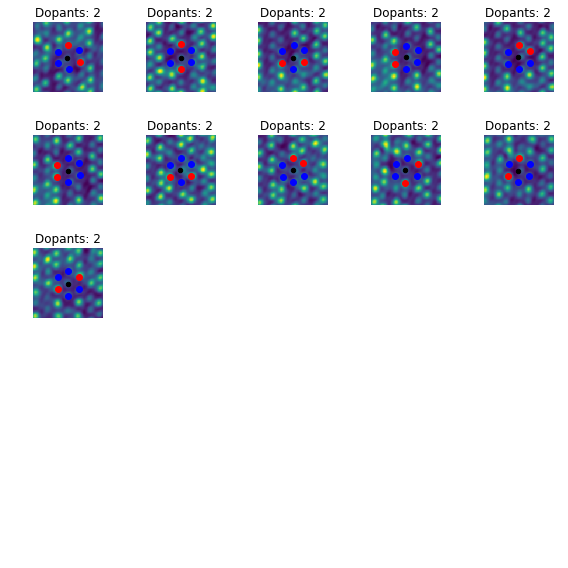

In [19]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 30 #For all atoms found within this radius, keep them
plot_dopant_number = 2 #number of dopants; if it equals this then it will be plotted.

#Here we want to plot any atom which has a dopant surrounding it.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (8,8))
flat_axes = axes.flat

ax_ind = 0

for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    plot_image = False
    #Plot the image only if a dopant atom is found. 
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1:
            plot_image =True
    
    if plot_image==False: #this means no NN were dopants
        histogram.append(1) #So this is the first type of configuration
    
    if plot_image==True:
        min_x_coord = int(max(0,x-win_size))
        max_x_coord = int(min(cropped_image.shape[1], x+win_size))

        min_y_coord = int(max(0,y-win_size))
        max_y_coord = int(min(cropped_image.shape[0], y+win_size))

        img_width =max_x_coord - min_x_coord 
        img_height =max_y_coord - min_y_coord

        if img_width<win_size*2: #ignore edge cases
            pass
        elif img_height<win_size*2:
            pass
        elif atom_ind==1:
            pass
        else:
            #Now that we have the neighbors, let's plot them.
            #First we plot the original atom.
            num_dopants=0
            dopant_neighbor = []
            for neighbor_ind in neighbors:
                if all_atoms_ids[neighbor_ind]==1: 
                    num_dopants+=1
                    dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
            
            
            if num_dopants ==plot_dopant_number: 
                shifted_x_pos = x-min_x_coord 
                shifted_y_pos = max_y_coord - y 

                cropped_atom_img = np.flipud(cropped_image[min_x_coord:max_x_coord, min_y_coord:max_y_coord])

                flat_axes[ax_ind].imshow(cropped_atom_img)

                flat_axes[ax_ind].scatter(shifted_y_pos, shifted_x_pos, c='black', s=20)


                for neighbor_ind in neighbors:

                    dopant_x, dopant_y = all_atoms[neighbor_ind,:]
                    #print(dopant_x, dopant_y,x,y)

                    dopant_shifted_x_pos = max_x_coord - dopant_x
                    dopant_shifted_y_pos = dopant_y -min_y_coord 

                    if all_atoms_ids[neighbor_ind]==1:
                        flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='r')
                    else:
                        flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='b')
                
                #dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2], dopant_neighbor[3]],:]
                #classification, distances = classify_four_dopant_class(dopant_points)
                
                #flat_axes[ax_ind].set_title('D: {} C: {}'.format(np.round(distances,1), classification))
                flat_axes[ax_ind].set_title('Dopants: {}'.format(num_dopants))
                flat_axes[ax_ind].axis('off')
                ax_ind = ax_ind+1

for ax in flat_axes: ax.axis('off')
fig.tight_layout()

# Configuration Possibilities

<font size = 3>The configurations we look for are plotted below. Again we only focus on Mo atoms neglecting the S lattice. We observe that there are 13 possible configurations. Others are not observed. </font>

<img src = "Mo_Re_configurations.png"></img>


In [20]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 30 #For all atoms found within this radius, keep them

#Here we want to plot any atom which has a dopant surrounding it.
histogram=[]
c=[]
for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    num_dopants=0
    dopant_neighbor = []
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1: 
            num_dopants+=1
            dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
    
    min_x_coord = int(max(0,x-win_size))
    max_x_coord = int(min(cropped_image.shape[1], x+win_size))

    min_y_coord = int(max(0,y-win_size))
    max_y_coord = int(min(cropped_image.shape[0], y+win_size))

    img_width =max_x_coord - min_x_coord 
    img_height =max_y_coord - min_y_coord

    if img_width<win_size*2: #ignore edge cases
        pass
    elif img_height<win_size*2:
        pass
    else:
        
        #Now investigate the neighbors. Classify each neighborhood according to distance rules.
        #There are 12 possible configurations.
        '''Configurations/Histogram entry:
            - 1 dopant: 1
            - 2 dopants: 2,3,4 (three variants)
            - 3 dopants: 5,6,7 (three variants)
            - 4 dopants: 8,9,10 (three variants)
            - 5 dopants: 11
            - 6 dopants: 12
            #We can distinguish the two dopant case fairly easily, based on distances. 
            #But what about the three dopant case? Well, again, summing distances to each other should work.
            #For four dopants it is tricky. If the two longest distances are equal, then it is the first case. 
            #If the sum of distances is smallest then it's the third case. Otherwise it's the second case
        '''
        
        if num_dopants==1 and atom_ind!=1:
            histogram.append(1) #only one configuration 
        elif num_dopants==2  and atom_ind!=1: #there are two types of configurations. So check which one...
            #the dopant atom indices are in dopant_neighbor.
            #calculate the distance between the dopant atoms
            
            x1,y1 =all_atoms[dopant_neighbor[0],:]
            x2,y2 =all_atoms[dopant_neighbor[1],:]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            #here we check for the type of configuration in the two dopant neighbor case
            if dist<=30:
                histogram.append(2) #cis
            elif dist>=35 and dist<=40:
                histogram.append(3) #trans-1
            else:
                histogram.append(4) #trans-2
                
        elif num_dopants ==3  and atom_ind!=1:
            #Now with the three dopants
            dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2]],:]
            three_dopant_class = classify_three_dopant_class(dopant_points)
            #print(three_dopant_class)
            c.append(three_dopant_class)
            histogram.append(three_dopant_class)
        elif num_dopants==4  and atom_ind!=1:
            dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2], dopant_neighbor[3]],:]
            four_dopant_class = classify_four_dopant_class(dopant_points)
            histogram.append(four_dopant_class)
        elif num_dopants==5  and atom_ind!=1:
            histogram.append(11)
        elif num_dopants==6  and atom_ind!=1:
            histogram.append(12)
        elif num_dopants==6  and atom_ind==1:
            histogram.append(13)


[0.0141844  0.02836879 0.03546099 0.0141844  0.0141844  0.04964539
 0.22695035 0.09929078 0.14893617 0.09929078 0.13475177 0.02836879
 0.10638298]


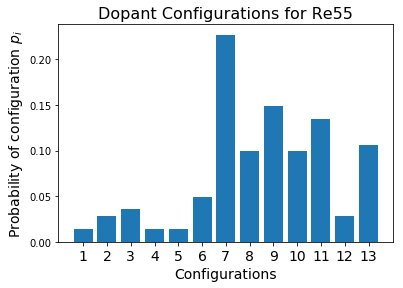

In [21]:
counts, bin_edges = np.histogram(histogram,bins=np.max(histogram), range=(1,13))
counts_norm = counts/len(histogram) #divide by number of counted configurations

fig, axes = plt.subplots();
axes.bar(np.arange(1,len(counts_norm)+1),counts_norm)
axes.set_xticks(np.arange(1,len(counts_norm)+1));
axes.set_xticklabels(np.arange(1,len(counts_norm)+1), fontsize = 14);
axes.set_title('Dopant Configurations for Re55', fontsize = 16);
axes.set_ylabel("Probability of configuration $p_i$", fontsize = 14);
axes.set_xlabel("Configurations", fontsize = 14);

print(counts_norm)

# Now analyze histogram of configurations with Re78

In [22]:
#let's look at the first one
#The atoms have been found and separated into sub lattices using Stephen's method.

h5_path = r're78.h5'
h5_file = h5py.File(h5_path, 'r+')
h5_raw = h5_file['Measurement_000']['Channel_000']['Raw_Data']

In [23]:
usid.hdf_utils.print_tree(h5_file)
atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
atom_centroids_2 =  atom_pos_grp['Atom_Centroids_2']
cropped_image = atom_pos_grp['Cropped_Image'][:]

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Atom_Positions
      --------------
      ├ Atom_Centroids_1
      ├ Atom_Centroids_2
      ├ Cropped_Image
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Windowing_000
      ----------------------
      ├ Image_Windows
      ├ Image_Windows-SVD_000
        ---------------------
        ├ Cleaned_Image_000
          -----------------
          ├ Cleaned_Image
        ├ Position_Indices
        ├ Position_Values
        ├ S
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
        ├ U
        ├ U-Cluster_000
          -------------
          ├ Cluster_Indices
          ├ Cluster_Values
          ├ Labels
          ├ Mean_Resp_Pos_Indices
          ├ Mean_Resp_Pos_Values
          ├ Mean_Response
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
        ├ V
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic

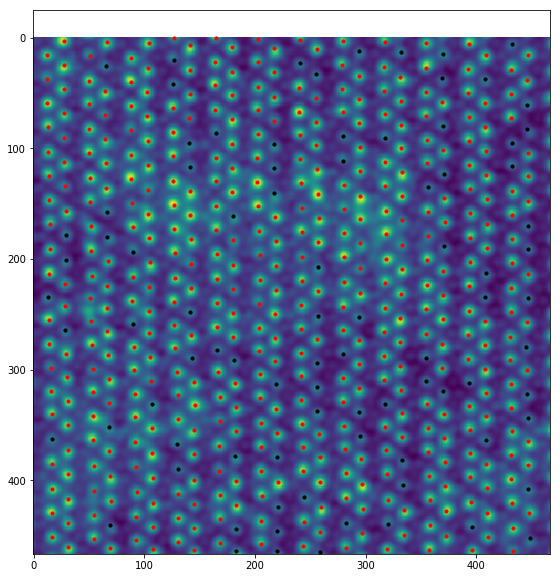

In [24]:
atom_centroids_full = np.vstack((atom_centroids_1, atom_centroids_2))

plt.figure(figsize = (10,10))
plt.imshow(cropped_image)
dopant_atoms = []
Mo_atoms=[]
for i in range(atom_centroids_full.shape[0]):
    x,y = atom_centroids_full[i,:]
    
    if cropped_image[int(x),int(y)]>=0.45:
        plt.scatter(atom_centroids_full[i,1],atom_centroids_full[i,0], c='r', s=10)
        dopant_atoms.append((x,y))
    else:
        plt.scatter(atom_centroids_full[i,1],atom_centroids_full[i,0], c='k', s=10)
        Mo_atoms.append((x,y))

In [25]:
Mo_atoms = np.array(Mo_atoms)
dopant_atoms = np.array(dopant_atoms)

all_atoms = np.vstack((Mo_atoms[:], dopant_atoms[:])) #ignoring the sulfur atoms for now.

print(all_atoms.shape)

all_atoms_ids = np.zeros(all_atoms.shape[0])
all_atoms_ids[:Mo_atoms.shape[0]]=0 #0 means Mo
all_atoms_ids[Mo_atoms.shape[0]:]=1 #1 is dopant atom
h5_file.file.close()

(520, 2)


In [26]:
#Some helper functions

def get_distance(atom_1,atom_2):
    return np.sqrt((atom_1[0]-atom_2[0])**2 + (atom_1[1]-atom_2[1])**2)

def classify_three_dopant_class(dopant_atom_pos):
    atom_1 = dopant_atom_pos[0,:]
    atom_2 = dopant_atom_pos[1,:]
    atom_3 = dopant_atom_pos[2,:]
    
    sum_distance = get_distance(atom_1,atom_2) + get_distance(atom_1,atom_3) + get_distance(atom_2,atom_3)
    
    if sum_distance<=85:
        three_d_class = 5
    elif sum_distance>85 and sum_distance<=106:
        three_d_class = 7
    else:
        three_d_class = 6
        
    return three_d_class

def classify_four_dopant_class(dopant_atom_pos):
    
    atom_1 = dopant_atom_pos[0,:]
    atom_2 = dopant_atom_pos[1,:]
    atom_3 = dopant_atom_pos[2,:]
    atom_4 = dopant_atom_pos[3,:]
    
    distances = []
    for atom_a, atom_b in [(atom_1, atom_2), (atom_1, atom_3), (atom_1, atom_4),
                          (atom_2,atom_3), (atom_2,atom_4), (atom_3, atom_4)]:
        distances.append(get_distance(atom_a, atom_b))
    
    sorted_dist = np.sort(distances)
    
    subtracted_dist = np.sum((distances[1] - distances[0]) + (distances[3]-distances[2]) + (distances[5] - distances[4]))
    
    sum_distance = get_distance(atom_1,atom_2) + get_distance(atom_1,atom_3) + get_distance(atom_1,atom_4) 
    + get_distance(atom_2,atom_3) + get_distance(atom_2, atom_4) + get_distance(atom_3, atom_4)
    
    if np.abs(subtracted_dist)<5:
        four_d_class = 8
    else:
        #Now to determine whether it is class 9 or 10 just look at the sum distance with the maximum distnace subtracted
        sorted_distance_new = sorted_dist[:-1]
        new_dist = np.sum(sorted_distance_new)
        if new_dist<=143:
            four_d_class = 10
        else:
            four_d_class = 9
        
    return four_d_class

# Plot the different types of configurations

Adjust the 'plot_dopant_number' variable below to see the configurations present for different number of NN dopant atoms

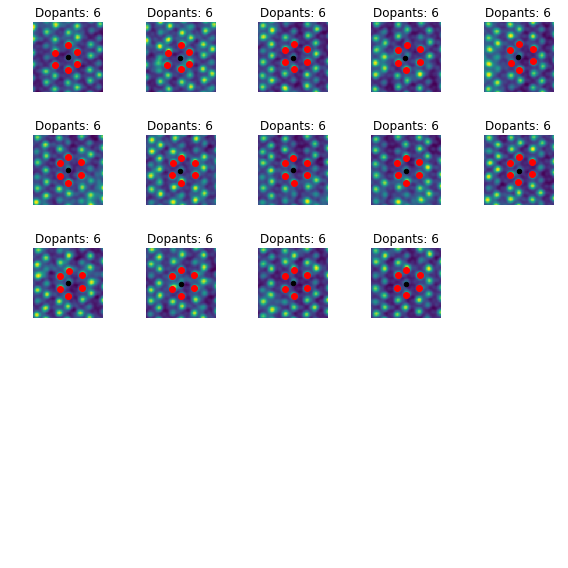

In [27]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 30 #For all atoms found within this radius, keep them
plot_dopant_number = 6 #number of dopants; if it equals this then it will be plotted.

#Here we want to plot any atom which has a dopant surrounding it.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (8,8))
flat_axes = axes.flat

ax_ind = 0

for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    plot_image = False
    #Plot the image only if a dopant atom is found. 
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1:
            plot_image =True
    
    if plot_image==False: #this means no NN were dopants
        histogram.append(1) #So this is the first type of configuration
    
    if plot_image==True:
        min_x_coord = int(max(0,x-win_size))
        max_x_coord = int(min(cropped_image.shape[1], x+win_size))

        min_y_coord = int(max(0,y-win_size))
        max_y_coord = int(min(cropped_image.shape[0], y+win_size))

        img_width =max_x_coord - min_x_coord 
        img_height =max_y_coord - min_y_coord

        if img_width<win_size*2: #ignore edge cases
            pass
        elif img_height<win_size*2:
            pass
        elif atom_ind==1:
            
            pass
        else:
            #Now that we have the neighbors, let's plot them.
            #First we plot the original atom.
            num_dopants=0
            dopant_neighbor = []
            for neighbor_ind in neighbors:
                if all_atoms_ids[neighbor_ind]==1: 
                    num_dopants+=1
                    dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
            
            
            if num_dopants ==plot_dopant_number: 
                shifted_x_pos = x-min_x_coord 
                shifted_y_pos = max_y_coord - y 

                cropped_atom_img = np.flipud(cropped_image[min_x_coord:max_x_coord, min_y_coord:max_y_coord])

                flat_axes[ax_ind].imshow(cropped_atom_img)

                flat_axes[ax_ind].scatter(shifted_y_pos, shifted_x_pos, c='black', s=20)


                for neighbor_ind in neighbors:

                    dopant_x, dopant_y = all_atoms[neighbor_ind,:]
                    #print(dopant_x, dopant_y,x,y)

                    dopant_shifted_x_pos = max_x_coord - dopant_x
                    dopant_shifted_y_pos = dopant_y -min_y_coord 

                    if all_atoms_ids[neighbor_ind]==1:
                        flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='r')
                    else:
                        flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='b')
                
                #dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2], dopant_neighbor[3]],:]
                #classification, distances = classify_four_dopant_class(dopant_points)
                
                #flat_axes[ax_ind].set_title('D: {} C: {}'.format(np.round(distances,1), classification))
                flat_axes[ax_ind].set_title('Dopants: {}'.format(num_dopants))
                flat_axes[ax_ind].axis('off')
                ax_ind = ax_ind+1

for ax in flat_axes: ax.axis('off')
fig.tight_layout()

# Configuration Possibilities for Re78

<font size = 3>The configurations we look for are plotted below. Again we only focus on Mo atoms neglecting the S lattice. We observe that there are 12 possible configurations. Others are not observed. </font>

<img src = "Mo_Re_configurations.png"></img>


In [28]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 30 #For all atoms found within this radius, keep them

#Here we want to plot any atom which has a dopant surrounding it.
histogram=[]
c=[]
for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    num_dopants=0
    dopant_neighbor = []
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1: 
            num_dopants+=1
            dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
    
    min_x_coord = int(max(0,x-win_size))
    max_x_coord = int(min(cropped_image.shape[1], x+win_size))

    min_y_coord = int(max(0,y-win_size))
    max_y_coord = int(min(cropped_image.shape[0], y+win_size))

    img_width =max_x_coord - min_x_coord 
    img_height =max_y_coord - min_y_coord

    if img_width<win_size*2: #ignore edge cases
        continue
    elif img_height<win_size*2:
        continue
    else:
        
        #Now investigate the neighbors. Classify each neighborhood according to distance rules.
        #There are 12 possible configurations.
        '''Configurations/Histogram entry:
            - 1 dopant: 1
            - 2 dopants: 2,3,4 (three variants)
            - 3 dopants: 5,6,7 (three variants)
            - 4 dopants: 8,9,10 (three variants)
            - 5 dopants: 11
            - 6 dopants: 12
            #We can distinguish the two dopant case fairly easily, based on distances. 
            #But what about the three dopant case? Well, again, summing distances to each other should work.
            #For four dopants it is tricky. If the two longest distances are equal, then it is the first case. 
            #If the sum of distances is smallest then it's the third case. Otherwise it's the second case
        '''
        
        if num_dopants==1 and atom_ind!=1:
            histogram.append(1) #only one configuration 
        elif num_dopants==2: #there are two types of configurations. So check which one...
            #the dopant atom indices are in dopant_neighbor.
            #calculate the distance between the dopant atoms
            
            x1,y1 =all_atoms[dopant_neighbor[0],:]
            x2,y2 =all_atoms[dopant_neighbor[1],:]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            #here we check for the type of configuration in the two dopant neighbor case
            if dist<=30:
                histogram.append(2) #cis
            elif dist>=35 and dist<=40:
                histogram.append(3) #trans-1
            else:
                histogram.append(4) #trans-2
                
        elif num_dopants ==3 and atom_ind!=1:
            #Now with the three dopants
            dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2]],:]
            three_dopant_class = classify_three_dopant_class(dopant_points)
            #print(three_dopant_class)
            c.append(three_dopant_class)
            histogram.append(three_dopant_class)
        elif num_dopants==4 and atom_ind!=1:
            dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2], dopant_neighbor[3]],:]
            four_dopant_class = classify_four_dopant_class(dopant_points)
            histogram.append(four_dopant_class)
        elif num_dopants==5 and atom_ind!=1:
            histogram.append(11)
        elif num_dopants==6 and atom_ind!=1:
            histogram.append(12)
        elif num_dopants==6 and atom_ind==1:
            histogram.append(13)

[0.         0.00775194 0.         0.         0.         0.
 0.         0.01550388 0.05426357 0.         0.17054264 0.10852713
 0.64341085]


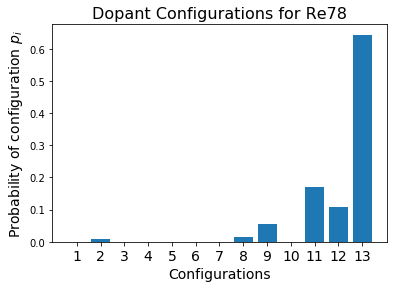

In [29]:
counts, bin_edges = np.histogram(histogram,bins=np.max(histogram),range=(1,13))
counts_norm = counts/len(histogram) #divide by number of counted configurations

fig, axes = plt.subplots();
axes.bar(np.arange(1,len(counts_norm)+1),counts_norm)
axes.set_xticks(np.arange(1,len(counts_norm)+1));
axes.set_xticklabels(np.arange(1,len(counts_norm)+1), fontsize = 14);
axes.set_title('Dopant Configurations for Re78', fontsize = 16);
axes.set_ylabel("Probability of configuration $p_i$", fontsize = 14);
axes.set_xlabel("Configurations", fontsize = 14);

print(counts_norm)

# Finally, analyze histogram of configurations with Re95

In [30]:
#let's look at the first one
#The atoms have been found and separated into sub lattices using Stephen's method.

h5_path = r're95.h5'
h5_file = h5py.File(h5_path, 'r+')
h5_raw = h5_file['Measurement_000']['Channel_000']['Raw_Data']

In [31]:
usid.hdf_utils.print_tree(h5_file)
atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
atom_centroids_2 =  atom_pos_grp['Atom_Centroids_2']
cropped_image = atom_pos_grp['Cropped_Image'][:]

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Atom_Positions
      --------------
      ├ Atom_Centroids_1
      ├ Atom_Centroids_2
      ├ Cropped_Image
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Windowing_000
      ----------------------
      ├ Image_Windows
      ├ Image_Windows-SVD_000
        ---------------------
        ├ Cleaned_Image_000
          -----------------
          ├ Cleaned_Image
        ├ Position_Indices
        ├ Position_Values
        ├ S
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
        ├ U
        ├ U-Cluster_000
          -------------
          ├ Cluster_Indices
          ├ Cluster_Values
          ├ Labels
          ├ Mean_Resp_Pos_Indices
          ├ Mean_Resp_Pos_Values
          ├ Mean_Response
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
        ├ V
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic

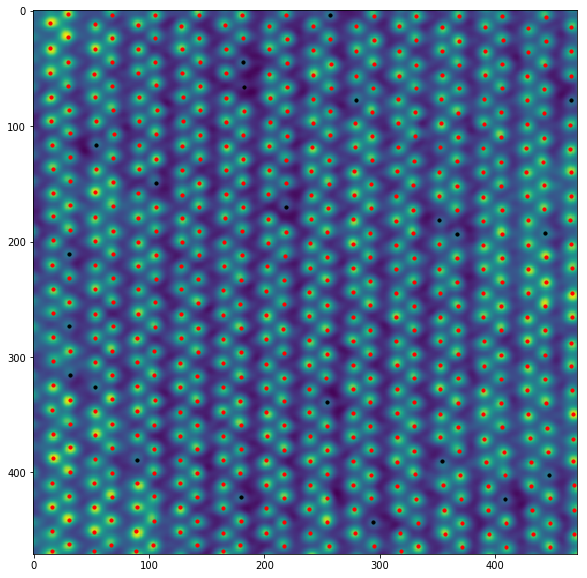

In [32]:
atom_centroids_full = np.vstack((atom_centroids_1, atom_centroids_2))

plt.figure(figsize = (10,10))
plt.imshow(cropped_image)
dopant_atoms = []
Mo_atoms=[]

for i in range(atom_centroids_full.shape[0]):
    x,y = atom_centroids_full[i,:]
    
    if cropped_image[int(x),int(y)]>=0.45:
        plt.scatter(atom_centroids_full[i,1],atom_centroids_full[i,0], c='r', s=10)
        dopant_atoms.append((x,y))
    else:
        plt.scatter(atom_centroids_full[i,1],atom_centroids_full[i,0], c='k', s=10)
        Mo_atoms.append((x,y))

In [33]:
Mo_atoms = np.array(Mo_atoms)
dopant_atoms = np.array(dopant_atoms)

all_atoms = np.vstack((Mo_atoms[:], dopant_atoms[:])) #ignoring the sulfur atoms for now.

print(all_atoms.shape)

all_atoms_ids = np.zeros(all_atoms.shape[0])
all_atoms_ids[:Mo_atoms.shape[0]]=0 #0 means Mo
all_atoms_ids[Mo_atoms.shape[0]:]=1 #1 is dopant atom

h5_file.file.close()

(567, 2)


# Plot the different types of configurations

Adjust the 'plot_dopant_number' variable below to see the configurations present for different number of NN dopant atoms

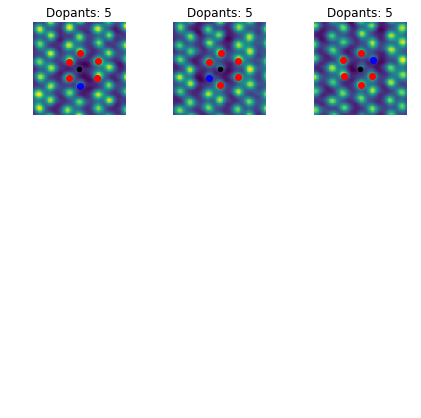

In [34]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 30 #For all atoms found within this radius, keep them
plot_dopant_number = 5 #number of dopants; if it equals this then it will be plotted.

#Here we want to plot any atom which has a dopant surrounding it.

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (6,6))
flat_axes = axes.flat

ax_ind = 0

for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    plot_image = False
    #Plot the image only if a dopant atom is found. 
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1:
            plot_image =True
    
    if plot_image==False: #this means no NN were dopants
        histogram.append(1) #So this is the first type of configuration
    
    if plot_image==True:
        min_x_coord = int(max(0,x-win_size))
        max_x_coord = int(min(cropped_image.shape[1], x+win_size))

        min_y_coord = int(max(0,y-win_size))
        max_y_coord = int(min(cropped_image.shape[0], y+win_size))

        img_width =max_x_coord - min_x_coord 
        img_height =max_y_coord - min_y_coord

        if img_width<win_size*2: #ignore edge cases
            continue
        elif img_height<win_size*2:
            continue
        elif atom_ind==1:
            continue
        else:
            #Now that we have the neighbors, let's plot them.
            #First we plot the original atom.
            num_dopants=0
            dopant_neighbor = []
            for neighbor_ind in neighbors:
                if all_atoms_ids[neighbor_ind]==1: 
                    num_dopants+=1
                    dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
            
            
            if num_dopants ==plot_dopant_number: 
                shifted_x_pos = x-min_x_coord 
                shifted_y_pos = max_y_coord - y 

                cropped_atom_img = np.flipud(cropped_image[min_x_coord:max_x_coord, min_y_coord:max_y_coord])

                flat_axes[ax_ind].imshow(cropped_atom_img)

                flat_axes[ax_ind].scatter(shifted_y_pos, shifted_x_pos, c='black', s=20)


                for neighbor_ind in neighbors:

                    dopant_x, dopant_y = all_atoms[neighbor_ind,:]
                    #print(dopant_x, dopant_y,x,y)

                    dopant_shifted_x_pos = max_x_coord - dopant_x
                    dopant_shifted_y_pos = dopant_y -min_y_coord 

                    if all_atoms_ids[neighbor_ind]==1:
                        flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='r')
                    else:
                        flat_axes[ax_ind].scatter(dopant_shifted_y_pos, dopant_shifted_x_pos, c='b')
                
                #dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2], dopant_neighbor[3]],:]
                #classification, distances = classify_four_dopant_class(dopant_points)
                
                #flat_axes[ax_ind].set_title('D: {} C: {}'.format(np.round(distances,1), classification))
                flat_axes[ax_ind].set_title('Dopants: {}'.format(num_dopants))
                flat_axes[ax_ind].axis('off')
                ax_ind = ax_ind+1

for ax in flat_axes: ax.axis('off')
fig.tight_layout()

In [35]:
#Plot the atom around the coordinate
win_size = 60
dist_thresh = 30 #For all atoms found within this radius, keep them

#Here we want to plot any atom which has a dopant surrounding it.
histogram=[]
c=[]
for i, atom_ind in enumerate(all_atoms_ids):

    x, y = all_atoms[i,:]
    dist_mat = dist_calc([x,y], all_atoms)

    neighbors = []
    for k in range(dist_mat.shape[0]):
        if dist_mat[k,0]<=dist_thresh and dist_mat[k,0]>0:
            neighbors.append(int(dist_mat[k,1]))

    num_dopants=0
    dopant_neighbor = []
    for neighbor_ind in neighbors:
        if all_atoms_ids[neighbor_ind]==1: 
            num_dopants+=1
            dopant_neighbor.append(neighbor_ind) #This list keeps tack of dopant neighbor atoms.
    
    min_x_coord = int(max(0,x-win_size))
    max_x_coord = int(min(cropped_image.shape[1], x+win_size))

    min_y_coord = int(max(0,y-win_size))
    max_y_coord = int(min(cropped_image.shape[0], y+win_size))

    img_width =max_x_coord - min_x_coord 
    img_height =max_y_coord - min_y_coord

    if img_width<win_size*2: #ignore edge cases
        continue
    elif img_height<win_size*2:
        continue

    else:
        
        #Now investigate the neighbors. Classify each neighborhood according to distance rules.
        #There are 12 possible configurations.
        '''Configurations/Histogram entry:
            - 1 dopant: 1
            - 2 dopants: 2,3,4 (three variants)
            - 3 dopants: 5,6,7 (three variants)
            - 4 dopants: 8,9,10 (three variants)
            - 5 dopants: 11
            - 6 dopants: 12
            #We can distinguish the two dopant case fairly easily, based on distances. 
            #But what about the three dopant case? Well, again, summing distances to each other should work.
            #For four dopants it is tricky. If the two longest distances are equal, then it is the first case. 
            #If the sum of distances is smallest then it's the third case. Otherwise it's the second case
        '''
        
        if num_dopants==1 and atom_ind!=1:
            histogram.append(1) #only one configuration 
            print('Found at {}'.format(i))
        elif num_dopants==2 and atom_ind!=1: #there are two types of configurations. So check which one...
            #the dopant atom indices are in dopant_neighbor.
            #calculate the distance between the dopant atoms
            
            x1,y1 =all_atoms[dopant_neighbor[0],:]
            x2,y2 =all_atoms[dopant_neighbor[1],:]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            #here we check for the type of configuration in the two dopant neighbor case
            if dist<=30:
                histogram.append(2) #cis
            elif dist>=35 and dist<=40:
                histogram.append(3) #trans-1
            else:
                histogram.append(4) #trans-2
                
        elif num_dopants ==3 and atom_ind!=1:
            #Now with the three dopants
            dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2]],:]
            three_dopant_class = classify_three_dopant_class(dopant_points)
            #print(three_dopant_class)
            c.append(three_dopant_class)
            histogram.append(three_dopant_class)
        elif num_dopants==4 and atom_ind!=1:
            dopant_points = all_atoms[[dopant_neighbor[0],dopant_neighbor[1], dopant_neighbor[2], dopant_neighbor[3]],:]
            four_dopant_class = classify_four_dopant_class(dopant_points)
            histogram.append(four_dopant_class)
        elif num_dopants==5 and atom_ind!=1:
            histogram.append(11)
        elif num_dopants==6 and atom_ind!=1:
            histogram.append(12)
        elif num_dopants==6 and atom_ind==1:
            histogram.append(13)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01119403 0.02238806
 0.96641791]


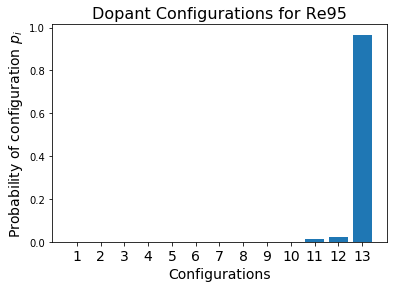

In [36]:
counts, bin_edges = np.histogram(histogram,bins=np.max(histogram), range=(1,13))
counts_norm = counts/len(histogram) #divide by number of counted configurations

fig, axes = plt.subplots();
axes.bar(np.arange(1,len(counts_norm)+1),counts_norm)
axes.set_xticks(np.arange(1,len(counts_norm)+1));
axes.set_xticklabels(np.arange(1,len(counts_norm)+1), fontsize = 14);
axes.set_title('Dopant Configurations for Re95', fontsize = 16);
axes.set_ylabel("Probability of configuration $p_i$", fontsize = 14);
axes.set_xlabel("Configurations", fontsize = 14);

print(counts_norm)